<a href="https://colab.research.google.com/github/KarsonLeperi/QuantFinance/blob/main/TA_MovingAverages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

In just getting started with exploring quanitative analysis, I wanted to start out with seeing if any excess returns can be acheived from using moving averages.

## Setup and Initial Exploration

In [ ]:
import warnings
warnings.filterwarnings('ignore')
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4039    0  4039    0     0   7446      0 --:--:-- --:--:-- --:--:--  7452
100  517k  100  517k    0     0   212k      0  0:00:02  0:00:02 --:--:--  391k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4047    0  4047    0     0   9022      0 --:--:-- --:--:-- --:--:--  9033
100  392k  100  392k    0     0   279k      0  0:00:01  0:00:01 --:--:--  456k


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import yfinance as yahoofin
from talib import SMA, EMA

Download training data, daily close prices for Microsoft from 2013 to 2023. Determine baseline performance (wait and hold Microsoft stock). In order to properly compare the performance of different strategies, stock performance will be baselined from the 200th entry.

In [ ]:
#Data Entry
startDate = datetime.datetime(2013, 1, 1)
endDate = datetime.datetime(2023, 12, 30)
company = "MSFT"

data = yahoofin.Ticker(company).history(start = startDate, end=endDate)
data_close = data[['Close', 'Open']]
baselinePerformance = data_close['Close'][-1]/data_close['Close'][200]
print(baselinePerformance)

12.885458051765154


Let's explore a 50/200 short/long moving average

In [ ]:
def backTesting(short_ma, long_ma, prices_data, ma = "SMA"):

  if ma == "EMA":
    prices_data["short_ma"] = EMA(prices_data['Close'], timeperiod = short_ma)
    prices_data["long_ma"] = EMA(prices_data['Close'], timeperiod = long_ma)
  else:
    prices_data["short_ma"] = SMA(prices_data['Close'], timeperiod = short_ma)
    prices_data["long_ma"] = SMA(prices_data['Close'], timeperiod = long_ma)

  prices_data = prices_data[200:]
  prices_data["signal"] = 0
  prices_data["signal"][prices_data["short_ma"]>= prices_data["long_ma"]] = 1

  prices_data["returns"] = prices_data["Close"].pct_change() * prices_data["signal"].shift(1)
  prices_data["cum_returns"] = (1 + prices_data["returns"]).cumprod()

  performance = prices_data["cum_returns"].iloc[-1]


  return prices_data, performance

10.471816781179529


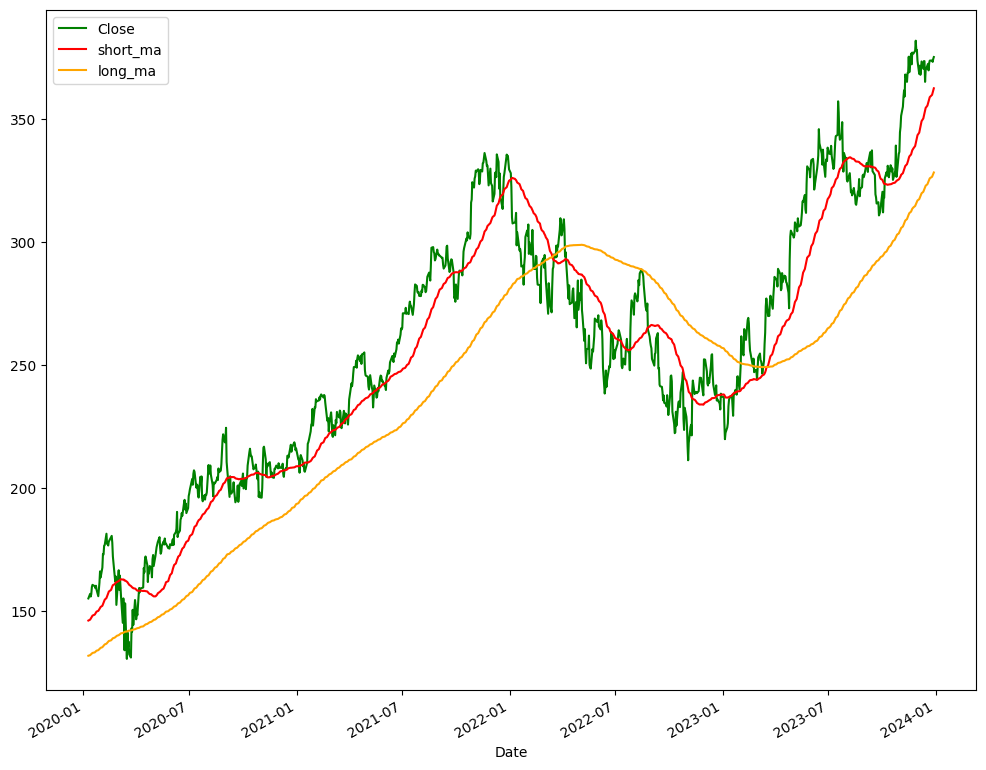

In [ ]:
SMA_50_200, performance_s_50_200 = backTesting(50, 200, data_close, "SMA")
SMA_50_200[['Close', 'short_ma', 'long_ma']].tail(1000).plot(figsize=(12,10), color=['green','red','orange'])
print(performance_s_50_200)

Well, looks like the strategy is not effective. The strategy results in only a 947% return over the decade, compared to the 1188% return for the buy and hold strategy. Let's see if EMA does any better.

11.339053759727168


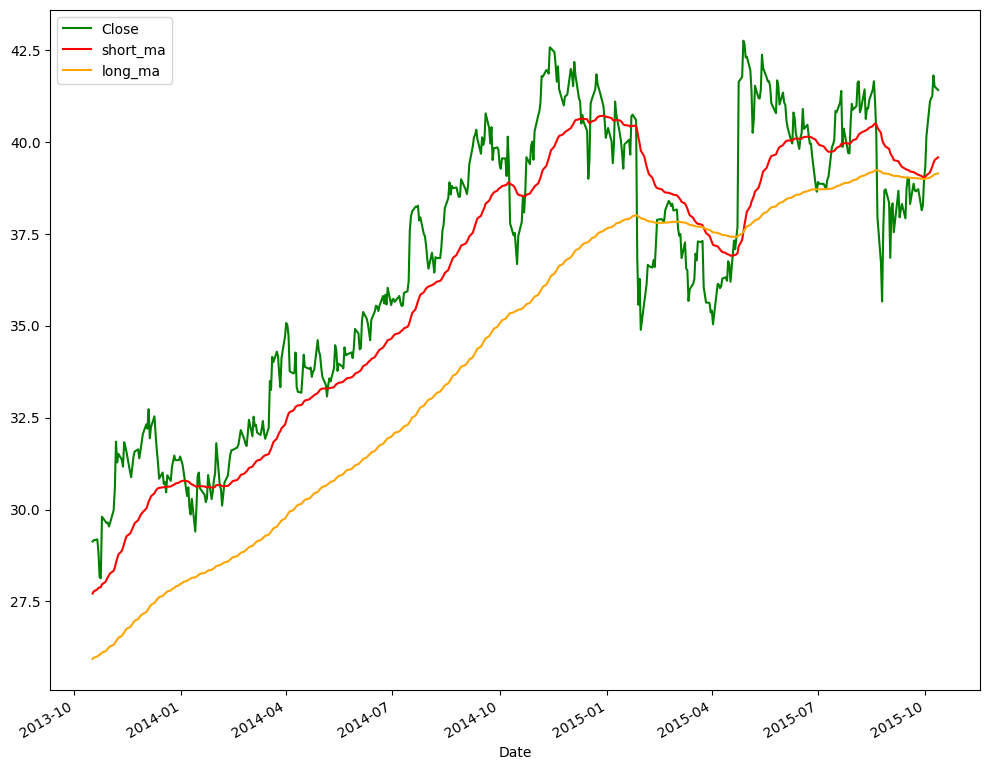

In [ ]:
EMA_50_200, performance_e_50_200 = backTesting(50, 200, data_close, "EMA")
EMA_50_200[['Close', 'short_ma', 'long_ma']].head(500).plot(figsize=(12,10), color=['green','red','orange'])
print(performance_e_50_200)

Better than the SMA (1034%), but still worse than Buy and Hold.

## Time Period Optimization

Since the 50/200 moving average performed worse than buy and hold, let's see if any other combination of time periods can beat the baseline.

In [ ]:
# Brute Force approach.


BF_performance_e = []
BF_performance_s = []
shortTP_list = []
longTP_list = []

for short_TP in range(2, 196):
  for long_TP in range(short_TP+5, 201):
    test, performance = backTesting(short_TP, long_TP, data_close, "EMA")
    BF_performance_e.append(performance)
    shortTP_list.append(short_TP)
    longTP_list.append(long_TP)


for short_TP in range(2, 196):
  for long_TP in range(short_TP+5, 201):
    test, performance = backTesting(short_TP, long_TP, data_close, "SMA")
    BF_performance_s.append(performance)


print(max(BF_performance_e))
print(max(BF_performance_s))




12.388007918878609
13.949554427413178


Looks like the simple moving average has some potential for increased returns. Let's plot both strategies to see any insights.

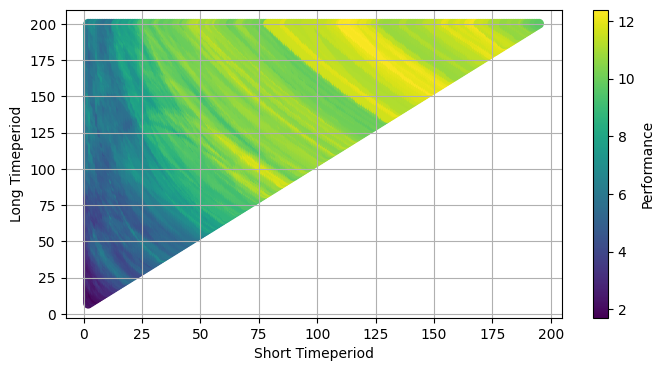

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(shortTP_list, longTP_list, c=BF_performance_e, marker='o')
plt.grid(True)
plt.xlabel('Short Timeperiod')
plt.ylabel('Long Timeperiod')
plt.colorbar(label='Performance')

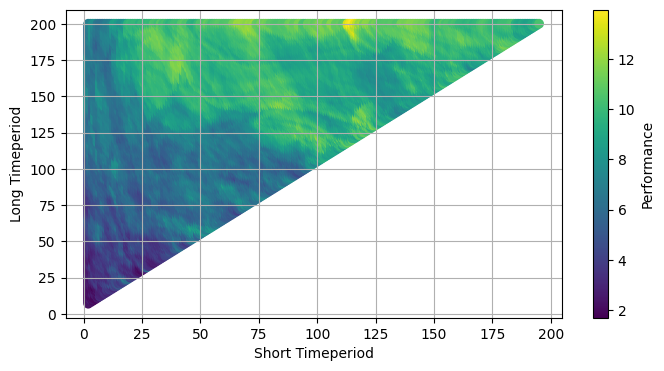

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(shortTP_list, longTP_list, c=BF_performance_s, marker='o')
plt.grid(True)
plt.xlabel('Short Timeperiod')
plt.ylabel('Long Timeperiod')
plt.colorbar(label='Performance')

In [ ]:
df = pd.DataFrame({"Performance": BF_performance_s, "Long Time":longTP_list, "Short Time":shortTP_list})
df.sort_values(["Performance"], ascending=False, inplace=True)
df.head(25)


,Performance,Long Time,Short Time
15674,13.949554,200,115
15593,13.687821,200,114
15592,13.642224,199,114
15673,13.469903,199,115
15754,13.377860,200,116
15828,13.306940,195,117
15672,13.246998,198,115
15827,13.232338,194,117
15750,13.223083,196,116
15511,13.185799,200,113


For the simple moving average, the top performers seem to be clustered around the long time period of 200 days and short time period of 115 days. From a robustness perspective, it is good to see there is not a steep drop off in performance moving away from the optimal point. Let's explore the specific strategy of 115/200.

For the expontential moving average, the optimal results seem to be in bands across the top right section of the graph. We do see that the 115/200 time period is also a top performing area.

Let's see see what buy and sell strategy looks like in terms of when the stocks were bought and sold.

In [ ]:
strategy, performance = backTesting(115, 200, data_close, "SMA")
strategy.loc[strategy["signal"]==0]

,Close,Open,short_ma,long_ma,signal,returns,cum_returns
Date,,,,,,,
2015-04-28 00:00:00-04:00,42.752609,41.552474,38.744459,38.760665,0,0.023527,1.467678
2015-04-29 00:00:00-04:00,42.665649,42.369964,38.750807,38.794313,0,-0.000000,1.467678
2015-04-30 00:00:00-04:00,42.300388,42.352569,38.754651,38.824813,0,-0.000000,1.467678
2015-05-01 00:00:00-04:00,42.317780,42.248208,38.752452,38.848449,0,0.000000,1.467678
2015-05-04 00:00:00-04:00,41.952541,42.065595,38.747302,38.868341,0,-0.000000,1.467678
...,...,...,...,...,...,...,...
2023-04-14 00:00:00-04:00,283.810699,284.663684,249.714689,251.651441,0,-0.000000,10.533685
2023-04-17 00:00:00-04:00,286.449005,287.569811,250.181989,251.802541,0,0.000000,10.533685
2023-04-18 00:00:00-04:00,286.022522,289.196485,250.677665,251.968393,0,-0.000000,10.533685


Looking at when the signal was 0 (when the stocks were sold and we had cash), we can see there were two times when we weren't invested. One in early 2015, and the other in 2022/2023. Off hand, I know tech stocks slumped in 2022 but I am not certain about the 2015 drop.

In [ ]:
date_range_1 = strategy.index.get_loc(datetime.datetime(2015, 1, 5))
date_range_2 = strategy.index.get_loc(datetime.datetime(2015, 12, 23))
date_range_3 = strategy.index.get_loc(datetime.datetime(2022, 1, 4))
date_range_4 = strategy.index.get_loc(datetime.datetime(2023, 8, 1))


<Axes: xlabel='Date'>

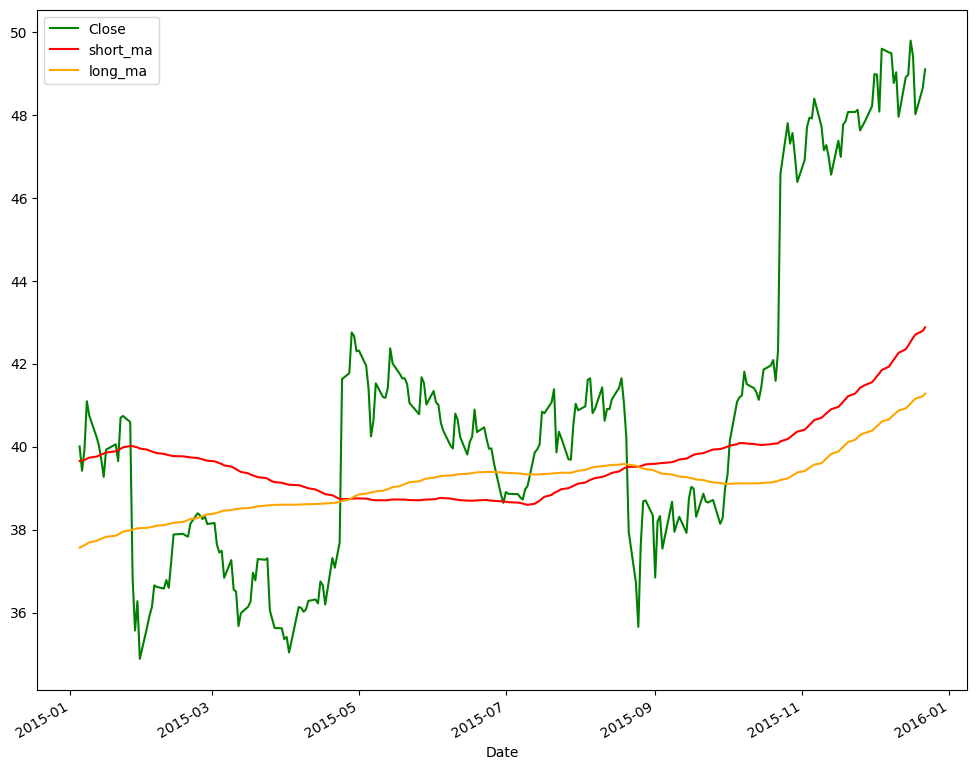

In [ ]:
strategy[['Close', 'short_ma', 'long_ma']][date_range_1:date_range_2].plot(figsize=(12,10), color=['green','red','orange'])

<Axes: xlabel='Date'>

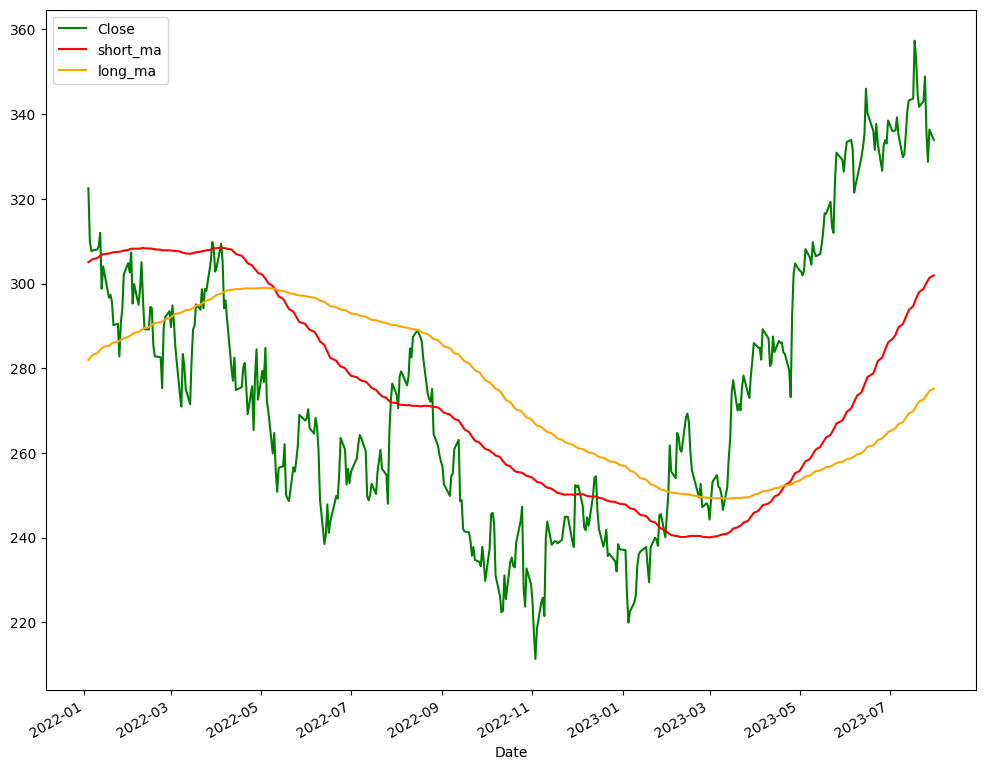

In [ ]:
strategy[['Close', 'short_ma', 'long_ma']][date_range_3:date_range_4].plot(figsize=(12,10), color=['green','red','orange'])

In [ ]:
print(42.75/36.72)
print(255.92 / 283.78)

1.1642156862745099
0.9018253576714357


Ah, looking at the 2015 chart, we can see our performance was due to timing spikes in the stock around q2 quarterly reports and another one in mid august. In both instances, the signal switched right after the spike. We can also see that the 2015 down turn was what caused our over performance as we lost money with the 2022/23 down turn.

## Validation

Let's see if our moving average strategy works with other stocks. In order to test it, let's look at Tesla and Amazon (two other growth stocks that might behave similarly to Microsoft) and Johnson and Johnson (a health stock that might behave differently).

In [ ]:
startDate = datetime.datetime(2013, 1, 1)
endDate = datetime.datetime(2023, 12, 30)
company = "TSLA"

TSLA_data = yahoofin.Ticker(company).history(start = startDate, end=endDate)
TSLA_data_close = TSLA_data[['Close', 'Open']]
TSLA_baselinePerformance = TSLA_data_close['Close'][-1]/TSLA_data_close['Close'][200]

TSLA_strategy, TSLA_performance = backTesting(115, 200, TSLA_data_close, "SMA")

print(TSLA_performance, TSLA_baselinePerformance)

4.72900510976542 20.38949506939193


In [ ]:
startDate = datetime.datetime(2013, 1, 1)
endDate = datetime.datetime(2023, 12, 30)
company = "AMZN"

AMZN_data = yahoofin.Ticker(company).history(start = startDate, end=endDate)
AMZN_data_close = AMZN_data[['Close', 'Open']]
AMZN_baselinePerformance = AMZN_data_close['Close'][-1]/AMZN_data_close['Close'][200]

AMZN_strategy, AMZN_performance = backTesting(115, 200, AMZN_data_close, "SMA")

print(AMZN_performance, AMZN_baselinePerformance)

8.757891108782058 9.778292890733356


In [ ]:
startDate = datetime.datetime(2013, 1, 1)
endDate = datetime.datetime(2023, 12, 30)
company = "JNJ"

JNJ_data = yahoofin.Ticker(company).history(start = startDate, end=endDate)
JNJ_data_close = JNJ_data[['Close', 'Open']]
JNJ_baselinePerformance = JNJ_data_close['Close'][-1]/JNJ_data_close['Close'][200]

JNJ_strategy, JNJ_performance = backTesting(115, 200, JNJ_data_close, "SMA")

print(JNJ_performance, JNJ_baselinePerformance)

1.3821408152608805 2.2529980428521674


Ooh, looks like the strategy massively underperformed on Tesla (373% vs 1939%). It also underperformed with Amazon and Johnson and Johnson. For all three stocks, the preference is to buy and hold

### Conclusion

After discovering that performance of the optimal moving average was due to timing a specific shock in the stock price, and seeing the massive underperformance of the strategy with Tesla (along with smaller underperformance with the other two stocks), it appears a simple moving average strategy in not recommended

### Future Work
For future work, I would like to combine the moving averages with other technical analysis indicators to see if we can improve the performance.